<a href="https://colab.research.google.com/github/ssubbinn/ESAA/blob/main/13%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

**규제 선형 모델의 개요**

최적 모델을 위한 cost 함수 구성요소 = 학습데이터 잔차 오류 최소화 + 회귀 계수 크기 제어

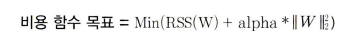

alpha : 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터

- alpha가 0이라면 비용 함수 식은 기존과 동일한 Min(RSS(W)+0)

- alpha가 무한대라면 비용 함수 식은 RSS(W)에 비해 alpha*|W값이 커지므로 W 값을 매우 작게 만들어야 cost 최소화 가능

- 즉, alpha를 0에서부터 지속적으로 값을 증가시키면 회귀 계수 값의 크기를 감소시킬 수 있다.

규제(regularizaion) : 비용함수에 alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적함을 개선하는 방식

- L2 규제 : W의 제곱에 대해 페널티 부여, L2 규제를 적용한 회귀를 릿지 회귀

- L1 규제 : W의 절댓값에 대해 페널티 부여,  L1 규제를 적용한 회귀는 리쏘 회귀


**릿지 회귀**

- ridge 클래스를 통해 릿지 회귀 구현. 주요 생성 파라미터는 alpha

In [1]:
# import package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score


boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
bostonDF['PRICE'] = boston.target
print('Boston 데이터셋 크기 : ', bostonDF.shape)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

Boston 데이터셋 크기 :  (506, 14)


In [2]:
# alpha=10으로 설정해 릿지 회귀 수행
ridge=Ridge(alpha=10)
neg_mse_scores=cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

print('5folds 의 개별 Negative MSE scores:', np.round(neg_mse_scores, 3))
print('5folds 의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5folds 의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5folds 의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5folds 의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5folds 의 평균 RMSE: 5.518


-> 릿지의 5개 폴드 세트의 평균 RMSE가 5.518 앞 규제가 없는 LinearRegression의 rsme평균보다 뛰어난 예측 성능 보임.

In [3]:
#alpha값을 변화시키면서 RMSE와 회귀 계수 값 변화 살펴보기.
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse 구함
for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    # cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

#alpha가 100일 때 평균 RMSE가 5.332로 가장 좋음

alpha 0 일 때 5 folds의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds의 평균 RMSE : 5.330 


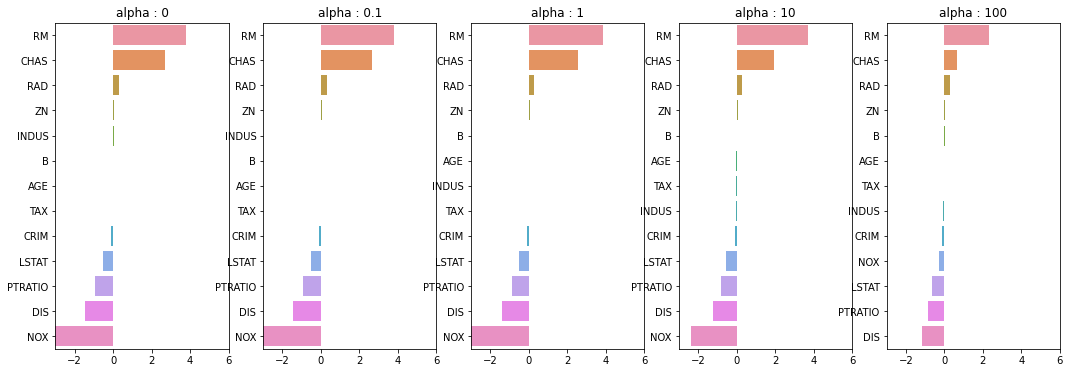

In [4]:
#alpha값의 변화에 따른 피처의 회귀 계수 값을 가로 막대 그래프로 시각화

#각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize = (18 ,6) , nrows = 1 , ncols = 5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 df생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
  
    # alpha에 따른 Feature 별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가 
    coeff = pd.Series(data = ridge.coef_, index = X_data.columns )
    colname = 'alpha : ' + str(alpha) # Column 이름 설정
    coeff_df[colname] = coeff

    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화
    coeff = coeff.sort_values(ascending = False) # 회귀 계수 값이 높은 순으로 표현
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3 ,6)
    sns.barplot(x = coeff.values , y = coeff.index, ax = axs[pos])

# for 문 밖에서 matplotlib의 show() 호출 및 alpha에 다른 피처별 회귀 계수를 dataframe으로 표시
plt.show()

alpha 값을 증가시킬수록 회귀 계수 값은 지속적으로 작아짐. 특히 NOX 피처

In [5]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha : ' + str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending = False)

,alpha : 0,alpha : 0.1,alpha : 1,alpha : 10,alpha : 100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있음, 0으로 만들지는 않음

**라쏘 회귀**

: L1규제를 선형회귀에 적용한 것

- L2 규제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거

In [6]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha = param)
        elif model_name =='Lasso': model = Lasso(alpha = param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha = param, l1_ratio = 0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = "neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE : {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
            coeff = pd.Series(data = model.coef_ , index = X_data_n.columns )
            colname ='alpha : ' + str(param)
            coeff_df[colname] = coeff
    
    return coeff_df
# end of get_linear_regre_eval

In [7]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas, X_data_n = X_data, y_target_n = y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.189 


alpha가 0.07일 때 가장 좋은 평균 RMSE를 보여줌 5.612

In [8]:
# alpha 값에 따른 피처별 회귀 계수
# 반환된 coeff_lasso_df를 첫번째 Column 순으로 내림차순 정렬하여 회귀계수 DataFrame 력
sort_column = 'alpha : ' + str(lasso_alphas[0])
coeff_lasso_df.sort_values(by = sort_column, ascending = False)

,alpha : 0.07,alpha : 0.1,alpha : 0.5,alpha : 1,alpha : 3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


alpha의 크기가 증가함에 따라 일부 피쳐의 회귀 계수는 0으로 바뀜 -> 피쳐 선택의 효과

**엘라스틱넷 회귀**

: L2 규제와 L1 규제를 결합한 회귀

- 엘라스틱넷의 규제는 a*L1 + b*L2, a는 L1 규제의 alpha값, b는 L2규제의 alpha 값
- alpha 파라미터 값은 a+b, l1_ratio 파라미터 값은 a/(a+b)

In [9]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의 하고 get_linear_reg_eval()함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas, X_data_n = X_data, y_target_n = y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.068 


In [10]:
# 반환된 coeff_elastic_df를 내림차순 정렬하여 회귀계수 DataFrame 출력
sort_column = 'alpha : ' + str(elastic_alphas[0])
coeff_elastic_df.sort_values(by = sort_column, ascending = False)

,alpha : 0.07,alpha : 0.1,alpha : 0.5,alpha : 1,alpha : 3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


alpha가 0.5일때 RMSE가 5.467로 가장 좋음, 라쏘 회귀에 비해 0이 되는 값이 적음

**선형 회귀 모델을 위한 데이터 변환**

- 타깃값의 경우 정규 분포 형태가 아니라 특정값의 분포가 치우친 왜곡(skew)된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높으므로 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적임

1. StandardScaler 클래스를 이용해 평균 0, 분산 1인 표준정규분포를 가진 데이터세트로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이 0, 최댓값이 1인 값으로 정규화 수행

2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환

3. 로그 변환

-> 타깃값은 일반적으로 로그 변환을 적용한다.

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음. 
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [15]:
#Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 rmse 추출.
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환. 먼저 원본 그대로, 표준 정규분포, 표준정규 분포 + 다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환 

scale_methods = [(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data = X_data)
    print('\n## 변환 유형 : {0}, Polynomial Degree : {1}'.format(scale_method[0], scale_method[1]))

    get_linear_reg_eval('Ridge', params = alphas, X_data_n = X_data_scaled, y_target_n = y_target, verbose = False, return_coeff = False)


## 변환 유형 : None, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 5.330 

## 변환 유형 : Standard, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 5.421 

## 변환 유형 : Standard, Polynomial Degree : 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 4.634 

## 변환 유형 : MinMax, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 7.635 

## 변환 유형 : MinMax, Polynomial Degree : 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.185 
alpha 100일 때 5 폴드 세트의 평균 RMSE : 6.538 

## 변환 유형 : Lo

- 표준 정규 분포와 최솟값 / 최댓값 정규화로 피처 데이터 세트를 변경해도 성능상의 개선은 없음

- 다항식 변화는 성능이 개선됨. 하지만 다항식 변환은 피처의 개수가 많을 경우 적용하기 힘들고 시간이 소모됨

- 로그변환은 모두 좋은 성능 향상이 있음

### 로지스틱 회귀

: 선형 회귀 방식을 분류에 적용한 알고리즘 (시그모이드 함수를 이용해 분류 수행)

In [16]:
#위스콘신 유방암 데이터 세트를 이용해 로지스틱 회귀로 암 여부 판단
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포 변환
scaler = StandardScaler() #정규 분포 형태의 표준 스케일링을 적용
data_scaled = scaler.fit_transform(cancer.data)
#데이터 셑 분리
X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state = 0)

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc 측정
print('accuracy : {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc : {:0.3f}'.format(roc_auc_score(y_test , lr_preds)))

accuracy : 0.977
roc_auc : 0.972


[LogisticRegression클래스의 주요 하이퍼 파라미터]

penalty = L1 규제 or L2 규제

C = 1/alpha


In [19]:
from sklearn.model_selection import GridSearchCV

params={'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring = 'accuracy', cv = 3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터 : {0}, 최적 평균 정확도 : {1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'}, 최적 평균 정확도 : 0.975


### 회귀 트리
회귀 트리:
- 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측
- 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산

In [20]:
#RandomForestRegressor이용 보스턴 주택 가격 예측
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# 보스턴 데이터셋 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1,inplace=False)

rf = RandomForestRegressor(random_state = 0, n_estimators = 1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores :  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


In [22]:
#랜덤포레스트 이외에 결정트리, XGB, XGBoost, LightGBMdml regressor을 모두 이용해 예측을 수행
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    print('##### ', model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]

for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
[07:00:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:00:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:00:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:00:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:00:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.089 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


coef_ 속성 없음. 대신 feature_importances_를 이용해 피처별 중요도 알 수 있음

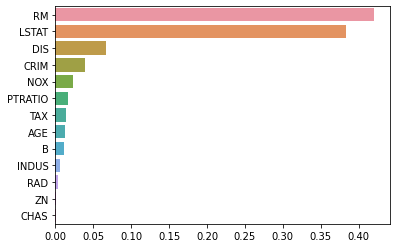

In [24]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators = 1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터셋을 적용해 학습  
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns )
feature_series = feature_series.sort_values(ascending = False) # 내림차순
sns.barplot(x = feature_series, y = feature_series.index)

(100, 2)


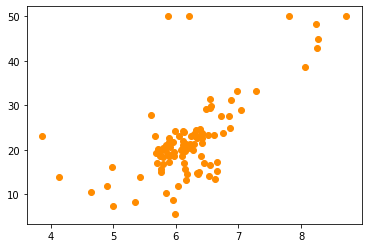

In [25]:
#선형 회귀와 비교해 시각화
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample( n =100, random_state = 0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")

In [26]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth = 2)
rf_reg7 = DecisionTreeRegressor(max_depth = 7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 테스트 데이터셋 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 RM, PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

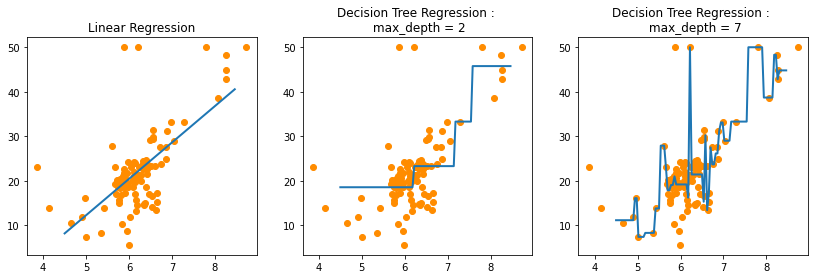

In [27]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize = (14,4), ncols = 3)

# X축 값을 4.5~ 8.5로 변환하며 입력했을 때 선형회귀와 결정 트리 회귀 예측선 시각화
#선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax1.plot(X_test, pred_lr,label = "linear", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression : \n max_depth = 2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax2.plot(X_test, pred_rf2, label = "max_depth : 3", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression : \n max_depth = 7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax3.plot(X_test, pred_rf7, label = "max_depth : 7", linewidth = 2)

- 선형 회귀는 직선으로 예측 회귀선을 표현하는데 반해, 회귀 트리의 경우 분할되는 데이터 지점에 다라 브랜치를 만들면서 계단 형태로 회귀선을 만든다.

- DecisionTreeRegressor의 max_depth=7인 경우에는 학습 데이터 세트의 이상치 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 되기 쉬운 모델이 되었음을 알 수 있음